In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          BertConfig,
                          BertTokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          BertForSequenceClassification)

set_seed(123)

epochs = 6
batch_size = 32
max_length = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'bert-large-uncased'
labels_ids = {0: 0, 1: 1}
n_labels = len(labels_ids)

/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


In [ ]:
import pandas as pd
class SarcasmDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, df, use_tokenizer):
    self.texts = []
    self.labels = []

    for index, row in df.iterrows():
      content = fix_text(row['headline'])
      self.texts.append(content)
      self.labels.append(row['is_sarcastic'])

    self.n_examples = len(self.labels)


    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """

    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.

    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask.

    It uses a given tokenizer and label encoder to convert any text and labels to numbers that
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len, )
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  global model

  predictions_labels = []
  true_labels = []

  total_loss = 0

  model.train()

  for batch in tqdm(dataloader, total=len(dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()

    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    model.zero_grad()
    outputs = model(**batch)

    loss, logits = outputs[:2]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    logits = logits.detach().cpu().numpy()

    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  global model

  predictions_labels = []
  true_labels = []

  total_loss = 0

  model.eval()

  for batch in tqdm(dataloader, total=len(dataloader)):

    true_labels += batch['labels'].numpy().flatten().tolist()

    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():

        outputs = model(**batch)

        loss, logits = outputs[:2]

        logits = logits.detach().cpu().numpy()

        total_loss += loss.item()

        predict_content = logits.argmax(axis=-1).flatten().tolist()

        predictions_labels += predict_content

  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Bert

In [ ]:
print('Loading configuraiton...')
model_config = BertConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

print('Loading tokenizer...')
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
#tokenizer = tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# default to left padding
#tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
#tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = model.config.eos_token_id

model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading tokenizer...


Loading model...


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly

Model loaded to `cuda`


In [ ]:
from sklearn.model_selection import train_test_split

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)

#df_v1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines = True)
#df = pd.concat([df_v1, df_v2], axis = 0)
train_df, test_df = train_test_split(df, test_size=0.2)

print('Dealing with Train...')

train_dataset = SarcasmDataset(train_df, use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))


print('Dealing with Validation...')
valid_dataset =  SarcasmDataset(test_df,
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealing with Train...
Created `train_dataset` with 22895 examples!
Created `train_dataloader` with 716 batches!

Dealing with Validation...
Created `valid_dataset` with 5724 examples!
Created `eval_dataloader` with 179 batches!


Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.27907 - val_loss: 0.20491 - train_acc: 0.88299 - valid_acc: 0.92610


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.11642 - val_loss: 0.17573 - train_acc: 0.96196 - valid_acc: 0.94147


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.04980 - val_loss: 0.31100 - train_acc: 0.98672 - valid_acc: 0.93938


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.01924 - val_loss: 0.34100 - train_acc: 0.99498 - valid_acc: 0.94217


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00697 - val_loss: 0.40210 - train_acc: 0.99817 - valid_acc: 0.94619


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00235 - val_loss: 0.44204 - train_acc: 0.99934 - valid_acc: 0.94497



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


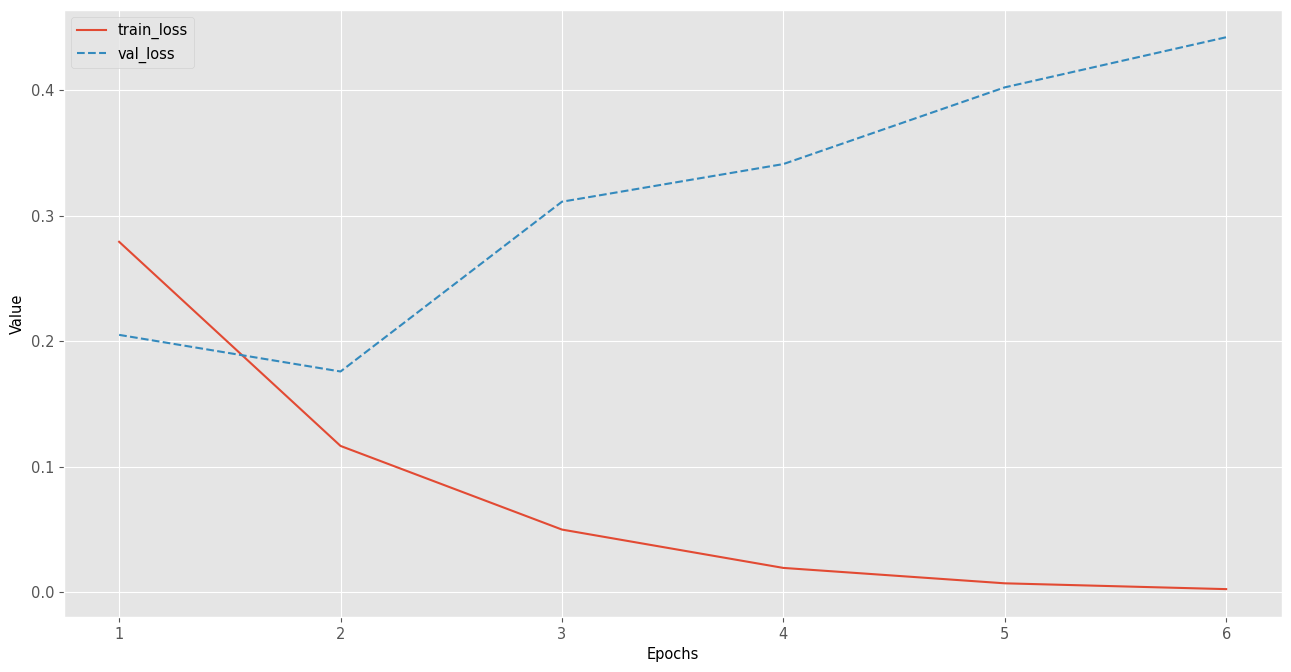

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


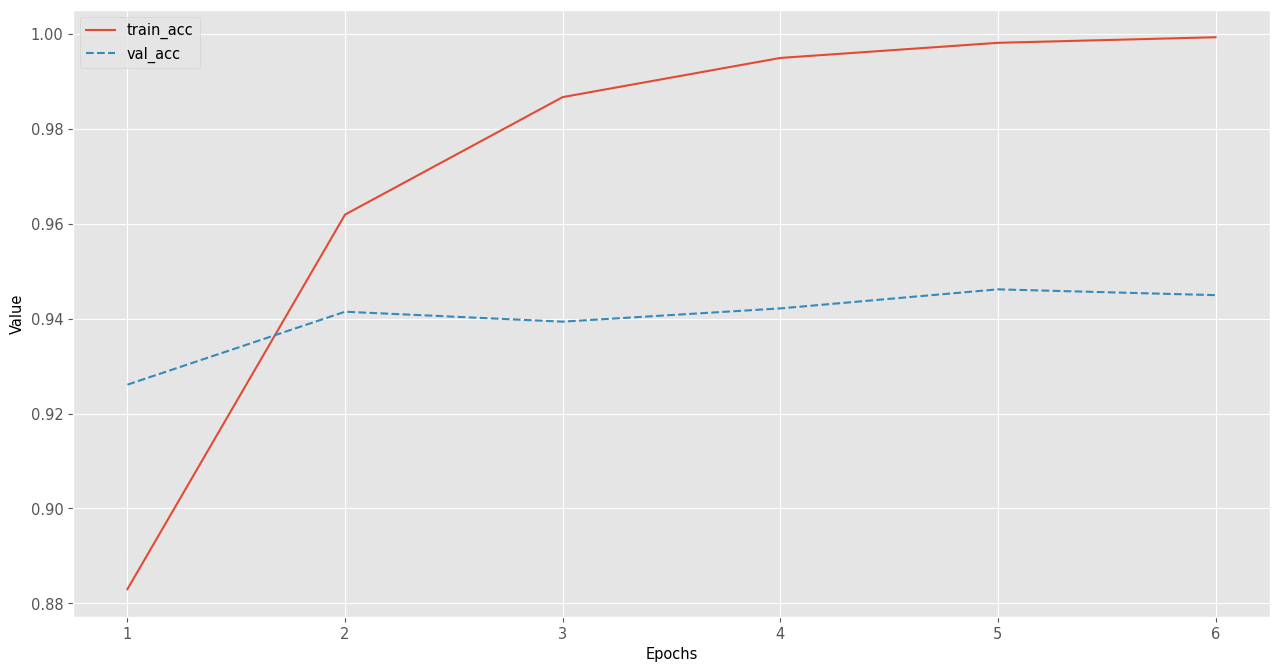

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')

  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)


plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/179 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2967
           1       0.96      0.92      0.94      2757

    accuracy                           0.94      5724
   macro avg       0.95      0.94      0.94      5724
weighted avg       0.95      0.94      0.94      5724

Normalized confusion matrix


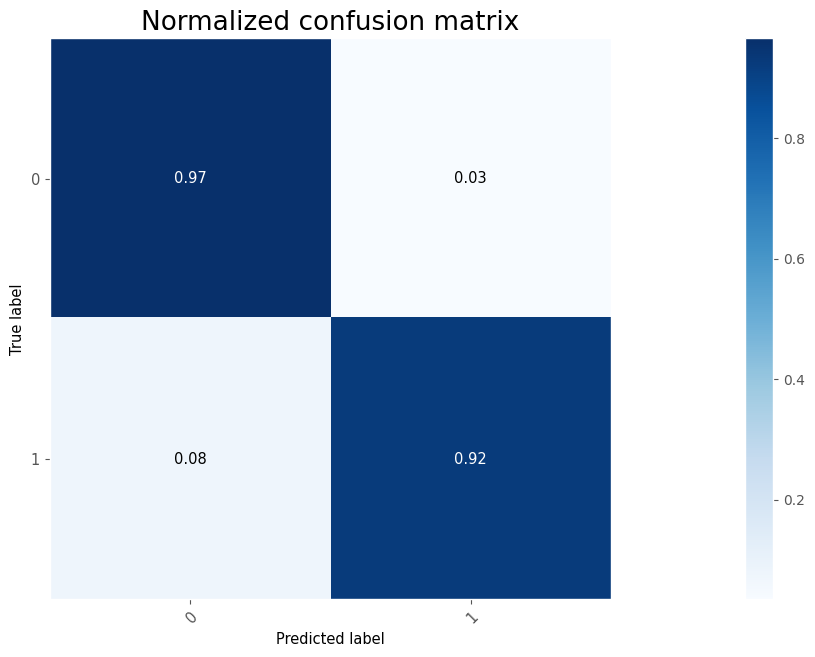

In [ ]:
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

evaluation_report = classification_report(true_labels, predictions_labels)
print(evaluation_report)

plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );


#Bert frozen

In [ ]:
print('Loading configuraiton...')
model_config = BertConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
print('Loading tokenizer...')
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
#tokenizer = tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# default to left padding
#tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
#tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = model.config.eos_token_id

model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...


Loading tokenizer...


Loading model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:
from sklearn.model_selection import train_test_split

gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)

#df_v1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines = True)
#df = pd.concat([df_v1, df_v2], axis = 0)
train_df, test_df = train_test_split(df, test_size=0.2)

print('Dealing with Train...')

train_dataset = SarcasmDataset(train_df, use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))


print('Dealing with Validation...')
valid_dataset =  SarcasmDataset(test_df,
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealing with Train...
Created `train_dataset` with 22895 examples!
Created `train_dataloader` with 716 batches!
Dealing with Validation...
Created `valid_dataset` with 5724 examples!
Created `eval_dataloader` with 179 batches!


Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.68725 - val_loss: 0.67252 - train_acc: 0.55016 - valid_acc: 0.61688


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.67876 - val_loss: 0.66592 - train_acc: 0.56925 - valid_acc: 0.62124


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.67176 - val_loss: 0.65966 - train_acc: 0.58362 - valid_acc: 0.63994


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.66627 - val_loss: 0.65544 - train_acc: 0.59603 - valid_acc: 0.64658


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.66358 - val_loss: 0.65452 - train_acc: 0.59777 - valid_acc: 0.63347


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.65949 - val_loss: 0.64906 - train_acc: 0.60817 - valid_acc: 0.65671


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.65564 - val_loss: 0.64602 - train_acc: 0.61839 - valid_acc: 0.65549


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.65422 - val_loss: 0.64399 - train_acc: 0.61830 - valid_acc: 0.66143


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.65391 - val_loss: 0.64324 - train_acc: 0.61695 - valid_acc: 0.66929


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.64981 - val_loss: 0.64087 - train_acc: 0.62608 - valid_acc: 0.66282


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.64785 - val_loss: 0.63962 - train_acc: 0.62996 - valid_acc: 0.66562


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.64835 - val_loss: 0.63924 - train_acc: 0.62586 - valid_acc: 0.66999


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.64738 - val_loss: 0.63814 - train_acc: 0.62839 - valid_acc: 0.66649


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.64616 - val_loss: 0.63796 - train_acc: 0.63219 - valid_acc: 0.66894


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.64755 - val_loss: 0.63768 - train_acc: 0.62905 - valid_acc: 0.66841



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


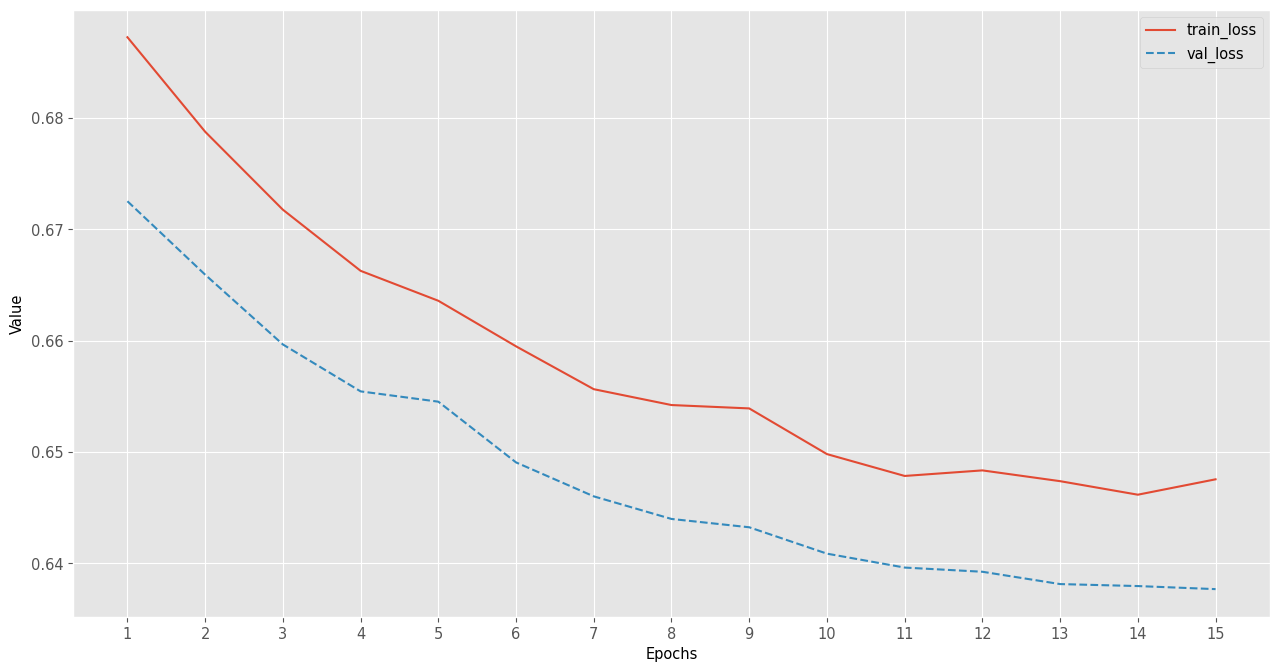

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


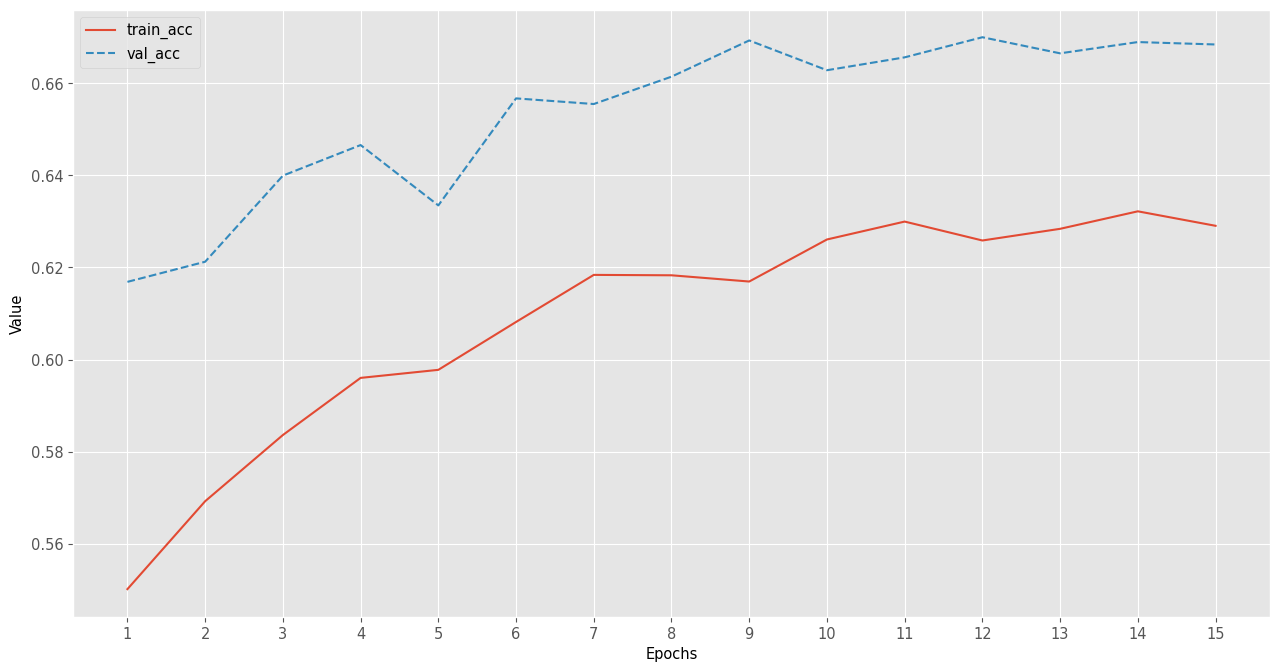

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )
epochs = 15

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

#Freeze weights in BERT backbone
for param in model.base_model.parameters():
    param.requires_grad = False


all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')

  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)


plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/179 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2967
           1       0.67      0.61      0.64      2757

    accuracy                           0.67      5724
   macro avg       0.67      0.67      0.67      5724
weighted avg       0.67      0.67      0.67      5724

Normalized confusion matrix


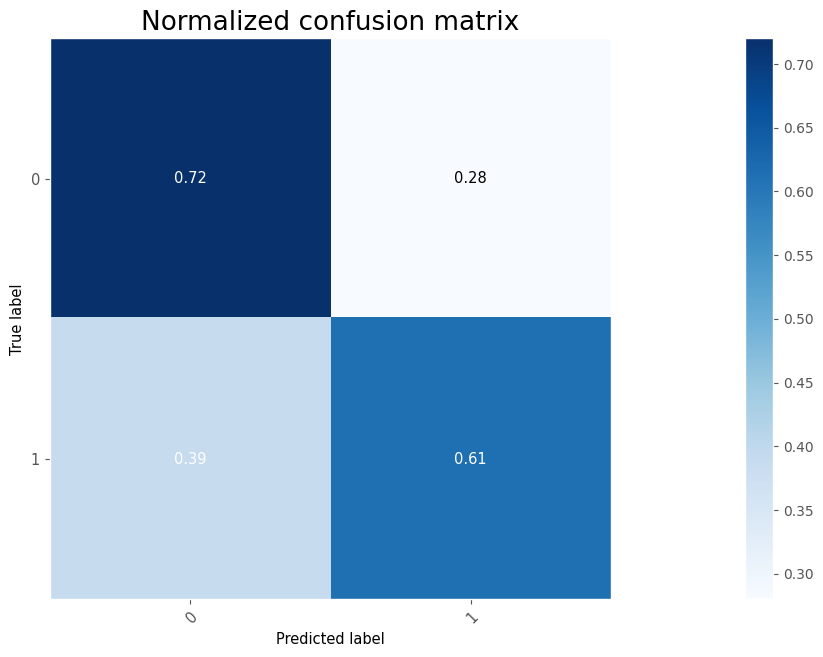

In [ ]:
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

evaluation_report = classification_report(true_labels, predictions_labels)
print(evaluation_report)

plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );

# DistillBert

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

#print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased', num_labels=n_labels)

print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased')
#tokenizer = tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# default to left padding
#tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
#tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

model.resize_token_embeddings(len(tokenizer))

model.config.pad_token_id = model.config.eos_token_id

model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading tokenizer...


Loading model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['transformer.layer.2.ffn.lin2.bias', 'transformer.layer.3.ffn.lin1.weight', 'transformer.layer.2.attention.out_lin.bias', 'transformer.layer.3.ffn.lin1.bias', 'transformer.layer.3.sa_layer_norm.weight', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.4.attention.k_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.1.ffn.lin1.bias', 'transformer.layer.5.ffn.lin1.weight', 'transformer.layer.4.sa_layer_norm.weight', 'transformer.layer.4.ffn.lin1.weight', 'transformer.layer.3.ffn.lin2.weight', 'transformer.layer.5.attention.k_lin.bias', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.1.attention.v_lin.bias', 'transformer.layer.4.ffn.lin1.bias', 'transformer.layer.2.attention.out_lin.weight', 'transformer.layer.4.attention.v_lin.bias', 'transformer.layer.5.

Model loaded to `cuda`


In [ ]:
from sklearn.model_selection import train_test_split


gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)

#df_v1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines = True)
#df = pd.concat([df_v1, df_v2], axis = 0)
train_df, test_df = train_test_split(df, test_size=0.2)

print('Dealing with Train...')

train_dataset = SarcasmDataset(train_df, use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))


print('Dealing with Validation...')
valid_dataset =  SarcasmDataset(test_df,
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dealing with Train...
Created `train_dataset` with 22895 examples!
Created `train_dataloader` with 716 batches!
Dealing with Validation...
Created `valid_dataset` with 5724 examples!
Created `eval_dataloader` with 179 batches!


Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.27495 - val_loss: 0.34680 - train_acc: 0.88736 - valid_acc: 0.86164


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.20545 - val_loss: 0.36451 - train_acc: 0.92090 - valid_acc: 0.85500


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.15493 - val_loss: 0.38323 - train_acc: 0.94239 - valid_acc: 0.86146


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.12030 - val_loss: 0.50146 - train_acc: 0.95938 - valid_acc: 0.85290


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.09190 - val_loss: 0.59576 - train_acc: 0.97161 - valid_acc: 0.85989


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.07432 - val_loss: 0.63947 - train_acc: 0.97681 - valid_acc: 0.85622


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.05807 - val_loss: 0.67658 - train_acc: 0.98388 - valid_acc: 0.85936


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.05250 - val_loss: 0.78934 - train_acc: 0.98585 - valid_acc: 0.85727


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.03906 - val_loss: 0.96290 - train_acc: 0.98960 - valid_acc: 0.85832


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.03384 - val_loss: 0.94566 - train_acc: 0.99135 - valid_acc: 0.85273


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.02440 - val_loss: 1.09085 - train_acc: 0.99358 - valid_acc: 0.85901


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.02629 - val_loss: 0.96055 - train_acc: 0.99393 - valid_acc: 0.85779


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.02110 - val_loss: 0.96446 - train_acc: 0.99472 - valid_acc: 0.85587


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.01605 - val_loss: 1.19045 - train_acc: 0.99616 - valid_acc: 0.86129


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.01252 - val_loss: 1.18125 - train_acc: 0.99699 - valid_acc: 0.85919


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.01071 - val_loss: 1.20033 - train_acc: 0.99808 - valid_acc: 0.86041


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.01442 - val_loss: 1.17036 - train_acc: 0.99672 - valid_acc: 0.85762


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00748 - val_loss: 1.35274 - train_acc: 0.99821 - valid_acc: 0.85447


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00929 - val_loss: 1.29708 - train_acc: 0.99790 - valid_acc: 0.85762


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00714 - val_loss: 1.38428 - train_acc: 0.99838 - valid_acc: 0.85797


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00603 - val_loss: 1.33355 - train_acc: 0.99886 - valid_acc: 0.86059


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00360 - val_loss: 1.51476 - train_acc: 0.99913 - valid_acc: 0.85779


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00428 - val_loss: 1.50966 - train_acc: 0.99917 - valid_acc: 0.85657


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00511 - val_loss: 1.45839 - train_acc: 0.99869 - valid_acc: 0.86181


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00141 - val_loss: 1.55536 - train_acc: 0.99965 - valid_acc: 0.85674


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00236 - val_loss: 1.60010 - train_acc: 0.99939 - valid_acc: 0.85517


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00331 - val_loss: 1.50098 - train_acc: 0.99917 - valid_acc: 0.85500


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00202 - val_loss: 1.50488 - train_acc: 0.99969 - valid_acc: 0.85849


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00051 - val_loss: 1.55121 - train_acc: 0.99983 - valid_acc: 0.85727


Training on batches...


  0%|          | 0/716 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/179 [00:00<?, ?it/s]

  train_loss: 0.00113 - val_loss: 1.54134 - train_acc: 0.99969 - valid_acc: 0.85727



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


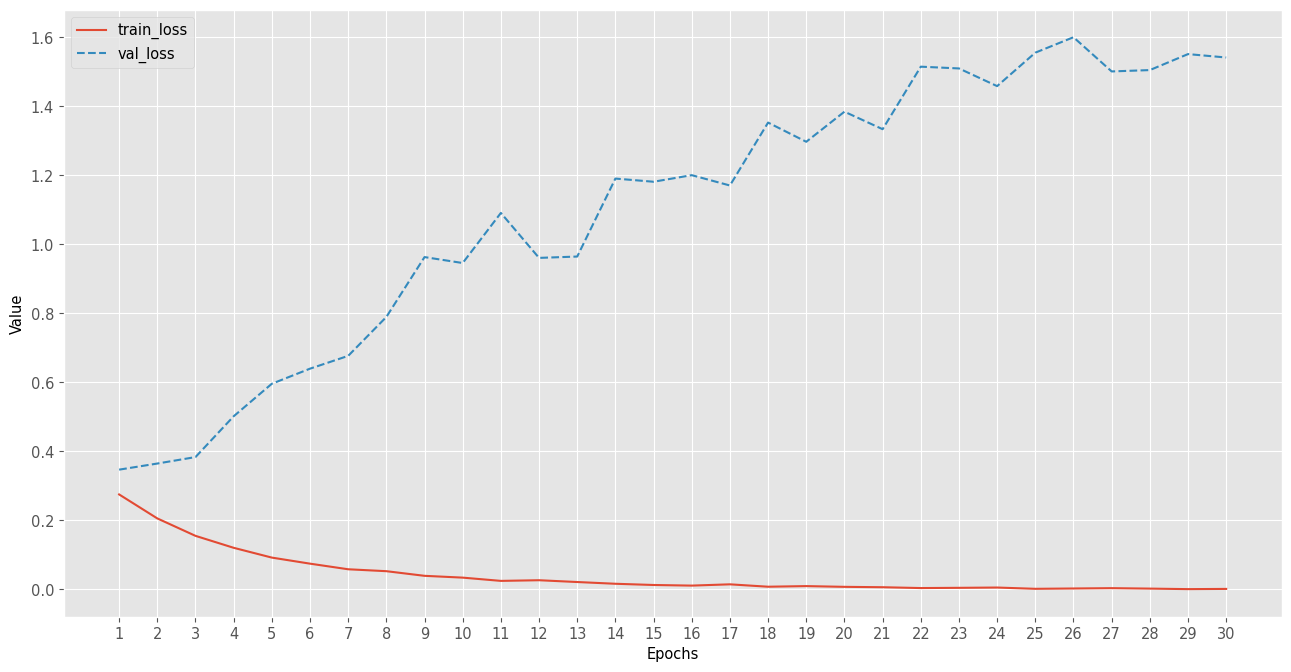

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


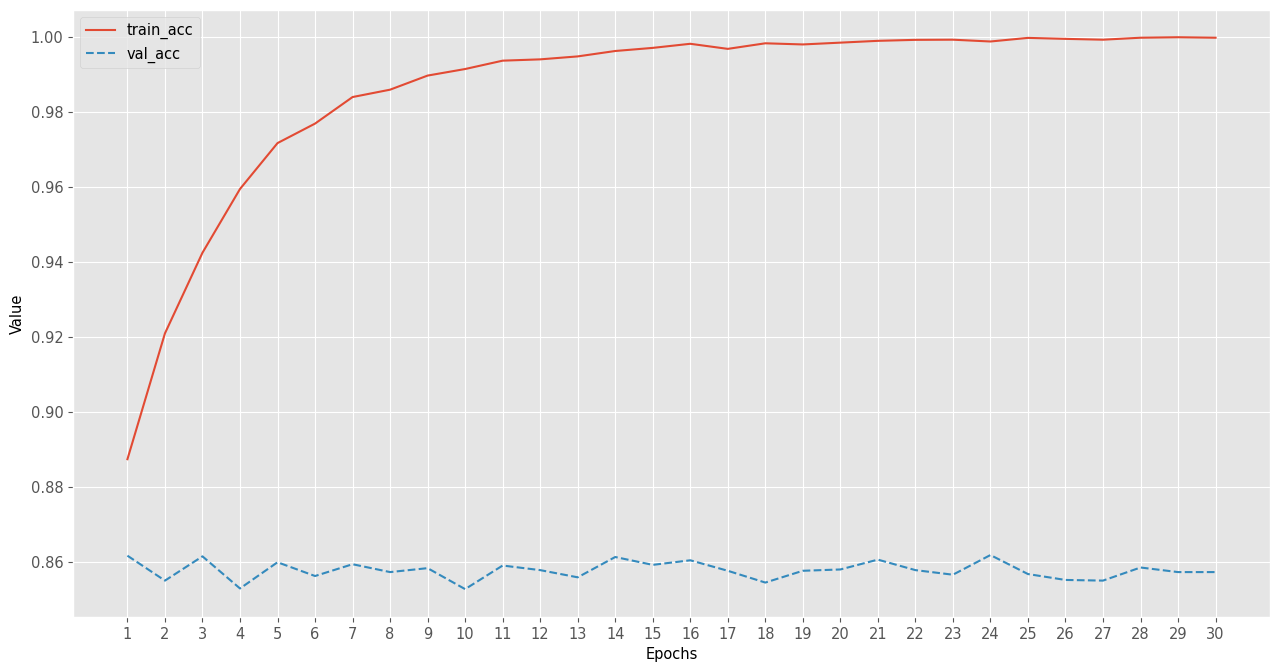

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )
epochs = 30


total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}



print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')

  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)


plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/179 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2967
           1       0.86      0.85      0.85      2757

    accuracy                           0.86      5724
   macro avg       0.86      0.86      0.86      5724
weighted avg       0.86      0.86      0.86      5724

Normalized confusion matrix


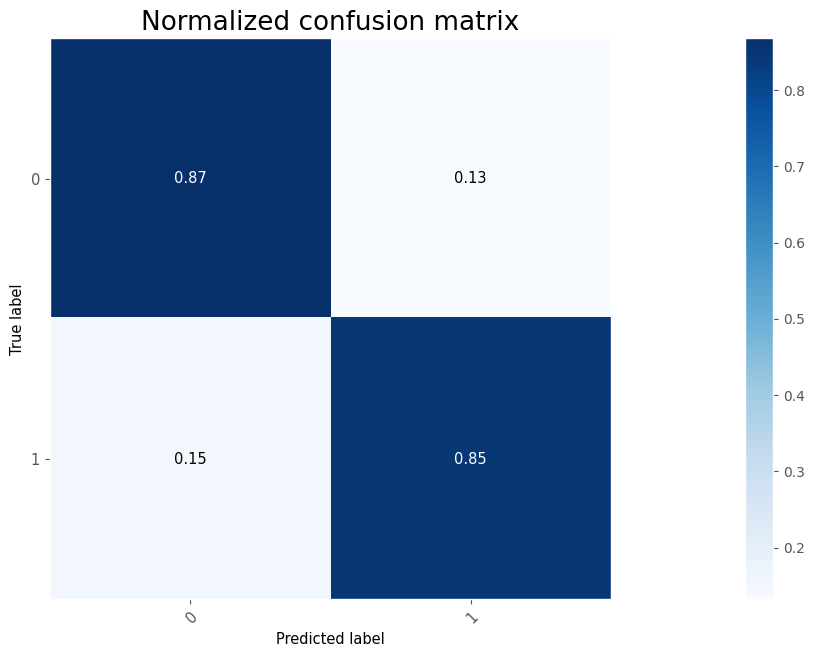

In [ ]:
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

evaluation_report = classification_report(true_labels, predictions_labels)
print(evaluation_report)

plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );


In [ ]:
model.save_pretrained("bert_frozen")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines = True)

In [ ]:
print(len(df[df.is_sarcastic == 1]))
print(len(df[df.is_sarcastic == 0]))
print(len(df))

13634
14985
28619


In [ ]:
!zip -r bert_frozen.zip bert_frozen/*

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  adding: bert_frozen/config.json (deflated 49%)
  adding: bert_frozen/pytorch_model.bin (deflated 7%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [ ]:
!cp bert_frozen.zip /content/drive/MyDrive

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
